# State Preparation Using Rotations

Controlled State preparation.

This algorithm prepares a state $|\psi\rangle$ in a register initially at $|0\rangle$ by using
rotations $R_y$ for encoding amplitudes and $R_z$ for encoding phases.

Assume one wants to prepare the amplitude of a one qubit state

$$
\sqrt{p_0} |0\rangle + \sqrt{p_1} |1\rangle.
$$

This can be achieved by a rotation $R_y(\theta)$ where $\theta = \cos^{-1}(\sqrt{p_0})$.
For encoding the amplitude of a n-qubit quantum state one could use a similar approach to this, but
chaining conditional probabilities: first rotate qubit 1 by $\theta = \cos^{-1}(\sqrt{p_0})$, then
the second qubit by $\theta_0 = \cos^{-1}(\sqrt{p_{00}/p_{0}})$, conditioned on the first one being
in $|0\rangle$ and $\theta_1 = \cos^{-1}(\sqrt{p_{10}/p_{1}})$ conditioned by the first being in
$|1\rangle$, and so on. Here $p_y$ means the probability that the first len(y) qubits of the
original state are in the state $y$. Refer to equation (8) of [1] for the details.

This general scheme is handled by StatePreparationViaRotations. This class also uses
RotationTree to get the angles of rotation needed (which are converted to the value to be loaded
to the ROM to achieve such a rotation). RotationTree is a tree data structure which holds the
accumulated probability of each substring, i.e., the root holds the probability of measuring the
first qubit at 0, the branch1 node the probability of measuring the second qubit at 0 if the first
was measured at 1 and so on. The $2^i$ rotations needed to prepare the ith qubit are performed by
PRGAViaPhaseGradient. This essentially is a rotation gate array, that is, given a list of
angles it performs the kth rotation when the selection register is on state $|k\rangle$. This
rotation is done in the Z axis, but for encoding amplitude a rotation around Ry is needed, thus the
need of a $R_x(\pm \pi/2)$ gate before and after encoding the amplitudes of each qubit.

In order to perform the rotations as efficiently as possible, the angles are loaded into a register
(rot\_reg) which is added into a phase gradient. Then phase kickback causes an overall offset of
$e^{i2\pi x/2^b}$, where $x$ is the angle value loaded and $b$ the size of the rot\_reg. Below is an
example for rot\_reg\_size=2.

First there is the rot\_reg register with the value to be rotated (3 in this case) and the phase
gradient

$$
|3\rangle(e^{2\pi i 0/4}|0\rangle + e^{2\pi i 1/4}|1\rangle +
          e^{2\pi i 2/4}|2\rangle + e^{2\pi i 3/4}|3\rangle).
$$

Then the rot\_reg $|3\rangle$ register is added to the phase gradient and store the result in the
phase gradient register

$$
|3\rangle(e^{2\pi i 0/4}|3\rangle + e^{2\pi i 1/4}|0\rangle +
          e^{2\pi i 2/4}|1\rangle + e^{2\pi i 3/4}|2\rangle),
$$

but this is equivalent to the original state with a phase offset of $e^{2\pi i 1/4}$.


References:
    [Trading T-gates for dirty qubits in state preparation and unitary synthesis]
    (https://arxiv.org/abs/1812.00954).
        Low, Kliuchnikov, Schaeffer. 2018.

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `StatePreparationViaRotations`
Controlled state preparation without entangled residual using Ry and Rz rotations from [1].

Given a quantum state of which the list of coefficients $c_i$ is known
$$
    |\psi \rangle = \sum_{i=0}^{N-1}c_{i}|i\rangle
$$
this gate prepares $|\psi\rangle$ from $|0\rangle$ conditioned by a control qubit
$$
    U((|0\rangle + |1\rangle)|0\rangle) = |0\rangle |0\rangle + |1\rangle |\psi\rangle.
$$

#### Parameters
 - `phase_bitsize`: size of the register that is used to store the rotation angles. Bigger values increase the accuracy of the results.
 - `state_coefficients`: tuple of length 2^state_bitsizes that contains the complex coefficients of the state.
 - `control_bitsize`: number of qubits of the control register. Set to zero for an uncontrolled gate. 

#### References
 - [Trading T-gates for dirty qubits in state preparation and unitary synthesis](https://arxiv.org/abs/1812.00954). Low, Kliuchnikov, Schaeffer. 2018.


In [2]:
from qualtran.bloqs.state_preparation import StatePreparationViaRotations

### Example Instances

In [3]:
state_coefs = (
    (-0.42677669529663675 - 0.1767766952966366j),
    (0.17677669529663664 - 0.4267766952966367j),
    (0.17677669529663675 - 0.1767766952966368j),
    (0.07322330470336305 - 0.07322330470336309j),
    (0.4267766952966366 - 0.17677669529663692j),
    (0.42677669529663664 + 0.17677669529663675j),
    (0.0732233047033631 + 0.17677669529663678j),
    (-0.07322330470336308 - 0.17677669529663678j),
)
state_prep_via_rotation = StatePreparationViaRotations(
    phase_bitsize=2, state_coefficients=state_coefs
)

In [4]:
from qualtran.symbolics import HasLength

n_state_coeff = sympy.Symbol("L")
phase_bitsize = sympy.Symbol(r"\text{phase_bitsize}")
state_prep_via_rotation_symb = StatePreparationViaRotations(
    state_coefficients=HasLength(n_state_coeff), phase_bitsize=phase_bitsize
)

#### Graphical Signature

In [5]:
from qualtran.drawing import show_bloqs
show_bloqs([state_prep_via_rotation, state_prep_via_rotation_symb],
           ['`state_prep_via_rotation`', '`state_prep_via_rotation_symb`'])

### Call Graph

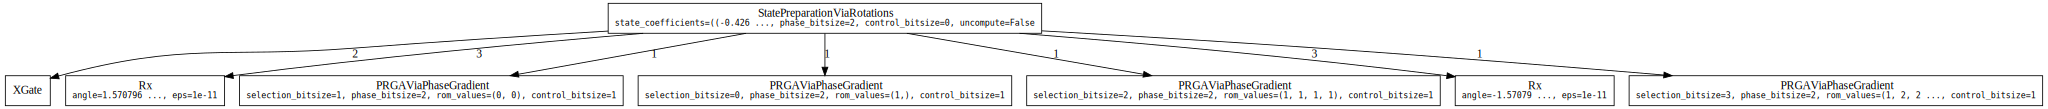

#### Counts totals:
 - `PRGAViaPhaseGradient`: 1
 - `PRGAViaPhaseGradient`: 1
 - `PRGAViaPhaseGradient`: 1
 - `PRGAViaPhaseGradient`: 1
 - `Rx(-0.5π)`: 3
 - `Rx(0.5π)`: 3
 - `XGate`: 2

In [6]:
from qualtran.resource_counting.generalizers import ignore_split_join
state_prep_via_rotation_g, state_prep_via_rotation_sigma = state_prep_via_rotation.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(state_prep_via_rotation_g)
show_counts_sigma(state_prep_via_rotation_sigma)